**The implementation in this notebook is partially based on the model described in** <br />
Kunang, Y. N., Nurmaini, S., Stiawan, D., & Suprapto, B. Y. (2021). Attack classification of an intrusion detection system using deep learning and hyperparameter optimization. *Journal of Information Security and Applications*, *58*, 102804. https://doi.org/10.1016/j.jisa.2021.102804

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [3]:
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# NSL-KDD

### List of attributes

In [5]:
attributes = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
    'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login',
    'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
    'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
    'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
    'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack_type','classifiers'
]

## Training Set

### KDDTrain+.txt
header = None is used since the first line in the .txt file is a record (a feature vector) <br />
index_col = False is used to avoid the automatic use of the first column as an index

In [6]:
train_set = pd.read_csv('KDDTrain+.txt', header = None, index_col = False, names = attributes)

services = train_set['service'].unique()
flags = train_set['flag'].unique()
protocols = train_set['protocol_type'].unique()

## Test Set

### KDDTest+.txt

In [7]:
test_set = pd.read_csv('KDDTest+.txt', header = None, index_col = False, names = attributes)

# Data Inspection

In [8]:
for df in [train_set, test_set]:
    print(df.isnull().sum().sum())

0
0


There are no missing values in the dataset

In [9]:
for df in [train_set, test_set]:
    for col in attributes:
        if(df[col].nunique()<2):
            print(col)

num_outbound_cmds
num_outbound_cmds


In [10]:
for df in [train_set, test_set]:
    print(df['num_outbound_cmds'].unique())

[0]
[0]


In [11]:
for df in [train_set, test_set]:
    print(df['service'].nunique())

70
64


In [12]:
isTrue = np.isin(test_set['service'].unique(), services)
print((isTrue == True).all())

True


In [13]:
services

array(['ftp_data', 'other', 'private', 'http', 'remote_job', 'name',
       'netbios_ns', 'eco_i', 'mtp', 'telnet', 'finger', 'domain_u',
       'supdup', 'uucp_path', 'Z39_50', 'smtp', 'csnet_ns', 'uucp',
       'netbios_dgm', 'urp_i', 'auth', 'domain', 'ftp', 'bgp', 'ldap',
       'ecr_i', 'gopher', 'vmnet', 'systat', 'http_443', 'efs', 'whois',
       'imap4', 'iso_tsap', 'echo', 'klogin', 'link', 'sunrpc', 'login',
       'kshell', 'sql_net', 'time', 'hostnames', 'exec', 'ntp_u',
       'discard', 'nntp', 'courier', 'ctf', 'ssh', 'daytime', 'shell',
       'netstat', 'pop_3', 'nnsp', 'IRC', 'pop_2', 'printer', 'tim_i',
       'pm_dump', 'red_i', 'netbios_ssn', 'rje', 'X11', 'urh_i',
       'http_8001', 'aol', 'http_2784', 'tftp_u', 'harvest'], dtype=object)

The service values are the same accross the entire dataset. **However**, KDDTest+ does not have all the services which will cause a problem in encoding.

In [14]:
for df in [train_set, test_set]:
    print(df['flag'].nunique())

11
11


In [15]:
isTrue = np.isin(test_set['flag'].unique(), flags)
print((isTrue == True).all())

True


The flag values are the same accross the entire dataset.

In [16]:
for df in [train_set, test_set]:
    print(df['protocol_type'].nunique())

3
3


In [17]:
isTrue = np.isin(test_set['protocol_type'].unique(), protocols)
print((isTrue == True).all())

True


The protocol values are the same accross the entire dataset.

# Data Preprocessing

Since **num_outbound_cmds** has only one value in the whole dataset, this column will be dropped since it has no effect on classification

In [18]:
for df in [train_set, test_set]:
    df.drop('num_outbound_cmds', axis = 1, inplace=True)

**classifiers** attribute is only useful for determining the level of difficulty of the record which would have no effect on classification

In [19]:
for df in [train_set, test_set]:
    df.drop('classifiers', axis = 1, inplace=True)

## 1. Adding columns

In [20]:
def add_missing_cols(df):
    missing = np.setdiff1d(services, df['service'].unique())
    for col in missing:
        df['service_{col}'.format(col = col)] = 0
    return df

### Adding attack categories column for multi-class classification

In [21]:
def categorize(str):
    if str in ['back', 'land', 'neptune', 'pod', 'smurf', 'mailbomb','teardrop','apache2', 'udpstorm', 'processtable', 'worm']:
        return 'dos'
    elif str in ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient', 'spy', 'xlock', 'xsnoop', 'snmpguess', 'snmpgetattack', 'httptunnel', 'sendmail', 'named']:
        return 'r2l'
    elif str in ['buffer_overflow', 'loadmodule', 'rootkit', 'perl', 'sqlattack', 'xterm', 'ps']:
        return 'u2r'
    elif str in ['satan', 'ipsweep', 'nmap', 'portsweep', 'mscan', 'saint']:
        return 'probe'
    else:
        return 'normal'
    
def categorize_attacks(df):
    df['category'] = np.vectorize(categorize)(df['attack_type'])

def display_categories(df):
    plt.figure(figsize =(10,7), dpi = 200)
    order = ['normal', 'dos', 'probe', 'r2l', 'u2r']
    ax = sns.countplot(x=df['category'], data = df, order=order)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+.4, p.get_height()), ha='center',size=14)
        
    plt.show()

In [22]:
for df in [train_set, test_set]:
    categorize_attacks(df)

All attacks were categorized

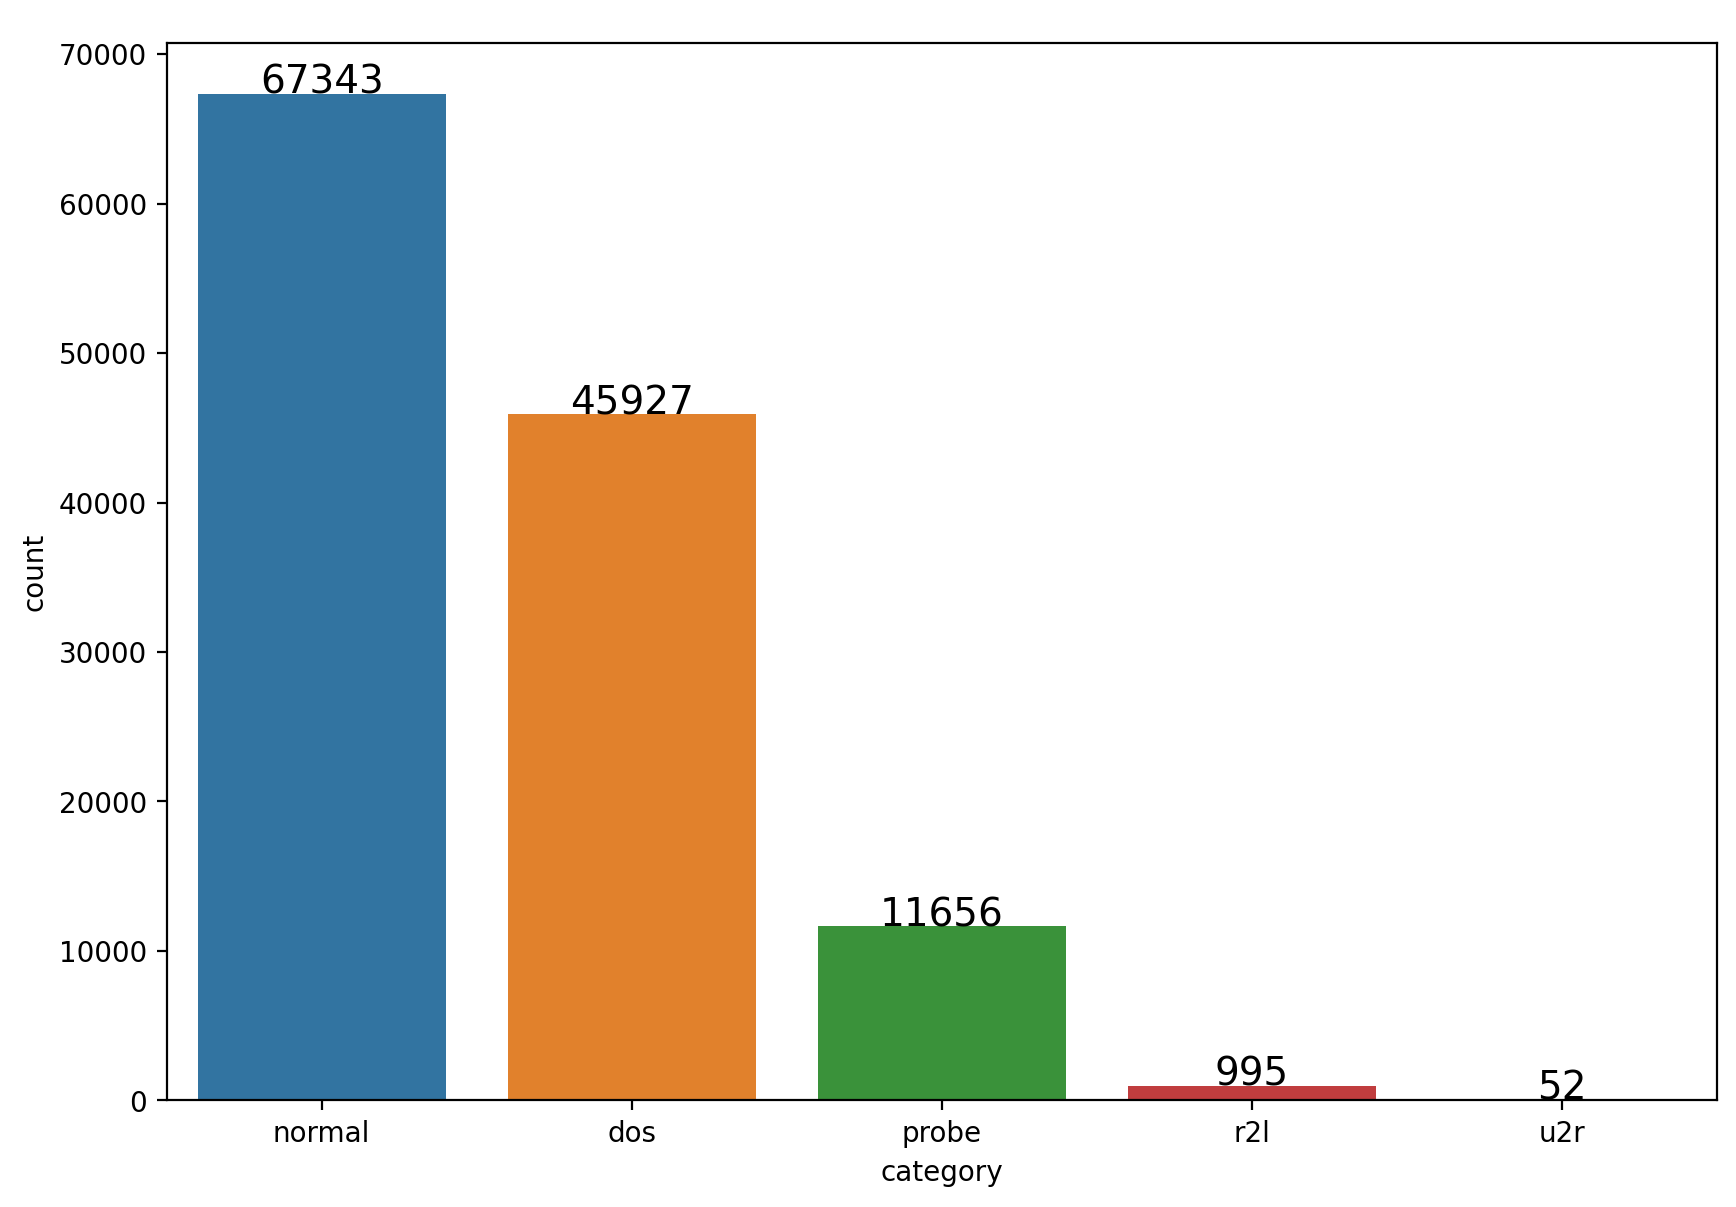

In [23]:
display_categories(train_set)

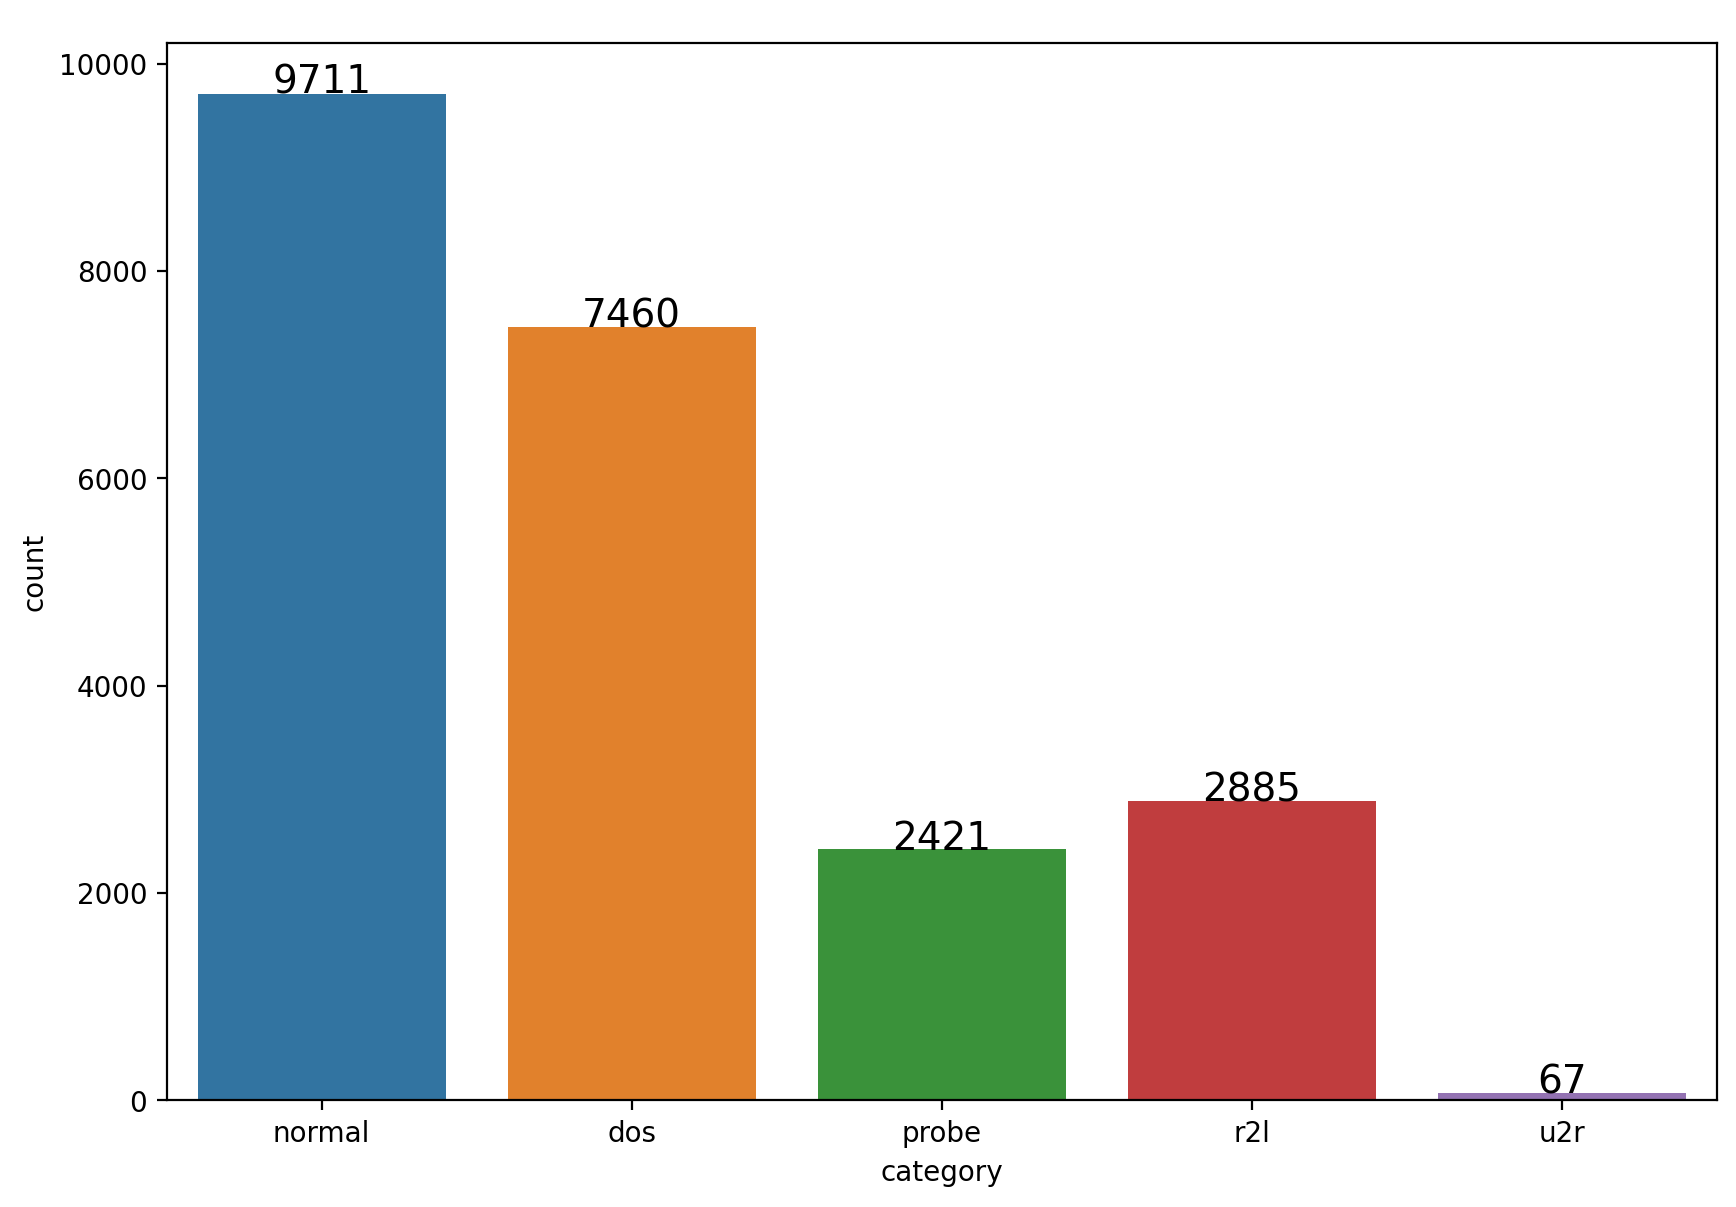

In [24]:
display_categories(test_set)

The distribution of records appears to be very imbalanced, especially in case of U2R attacks.

### Adding labels for binary classification

In [25]:
def binary_labels(str):
    if str in ['dos', 'r2l', 'probe', 'u2r']:
        return 'attack'
    else:
        return 'normal'
       
def add_binary_labels(df):
    df['traffic_type'] = np.vectorize(binary_labels)(df['category'])
    
def display_traffic_type(df):
    plt.figure(figsize =(10,7), dpi = 200)
    order = ['normal', 'attack']
    ax = sns.countplot(x=df['traffic_type'], data = df, order=order)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+.4, p.get_height()), ha='center',size=14)
        
    plt.show()

In [26]:
for df in [train_set, test_set]:
    add_binary_labels(df)

Binary labels were added.

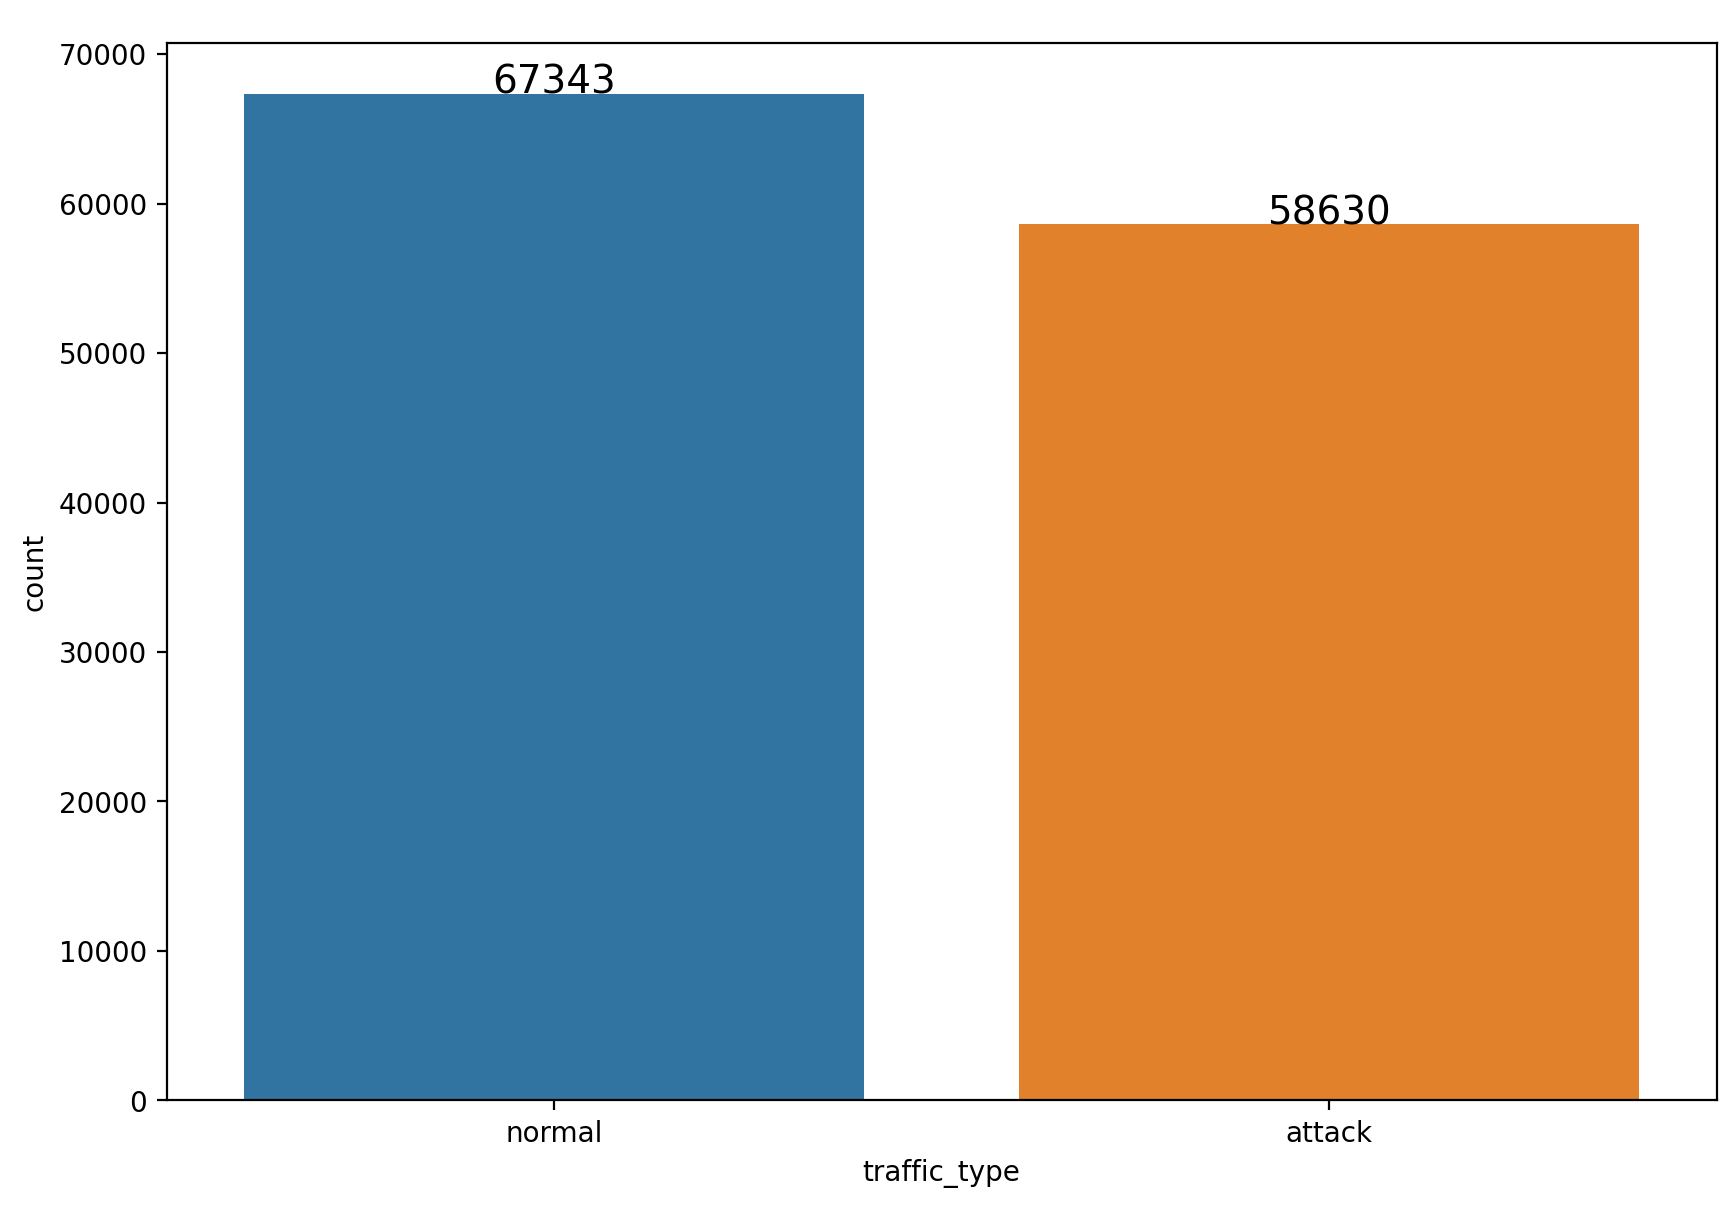

In [27]:
display_traffic_type(train_set)

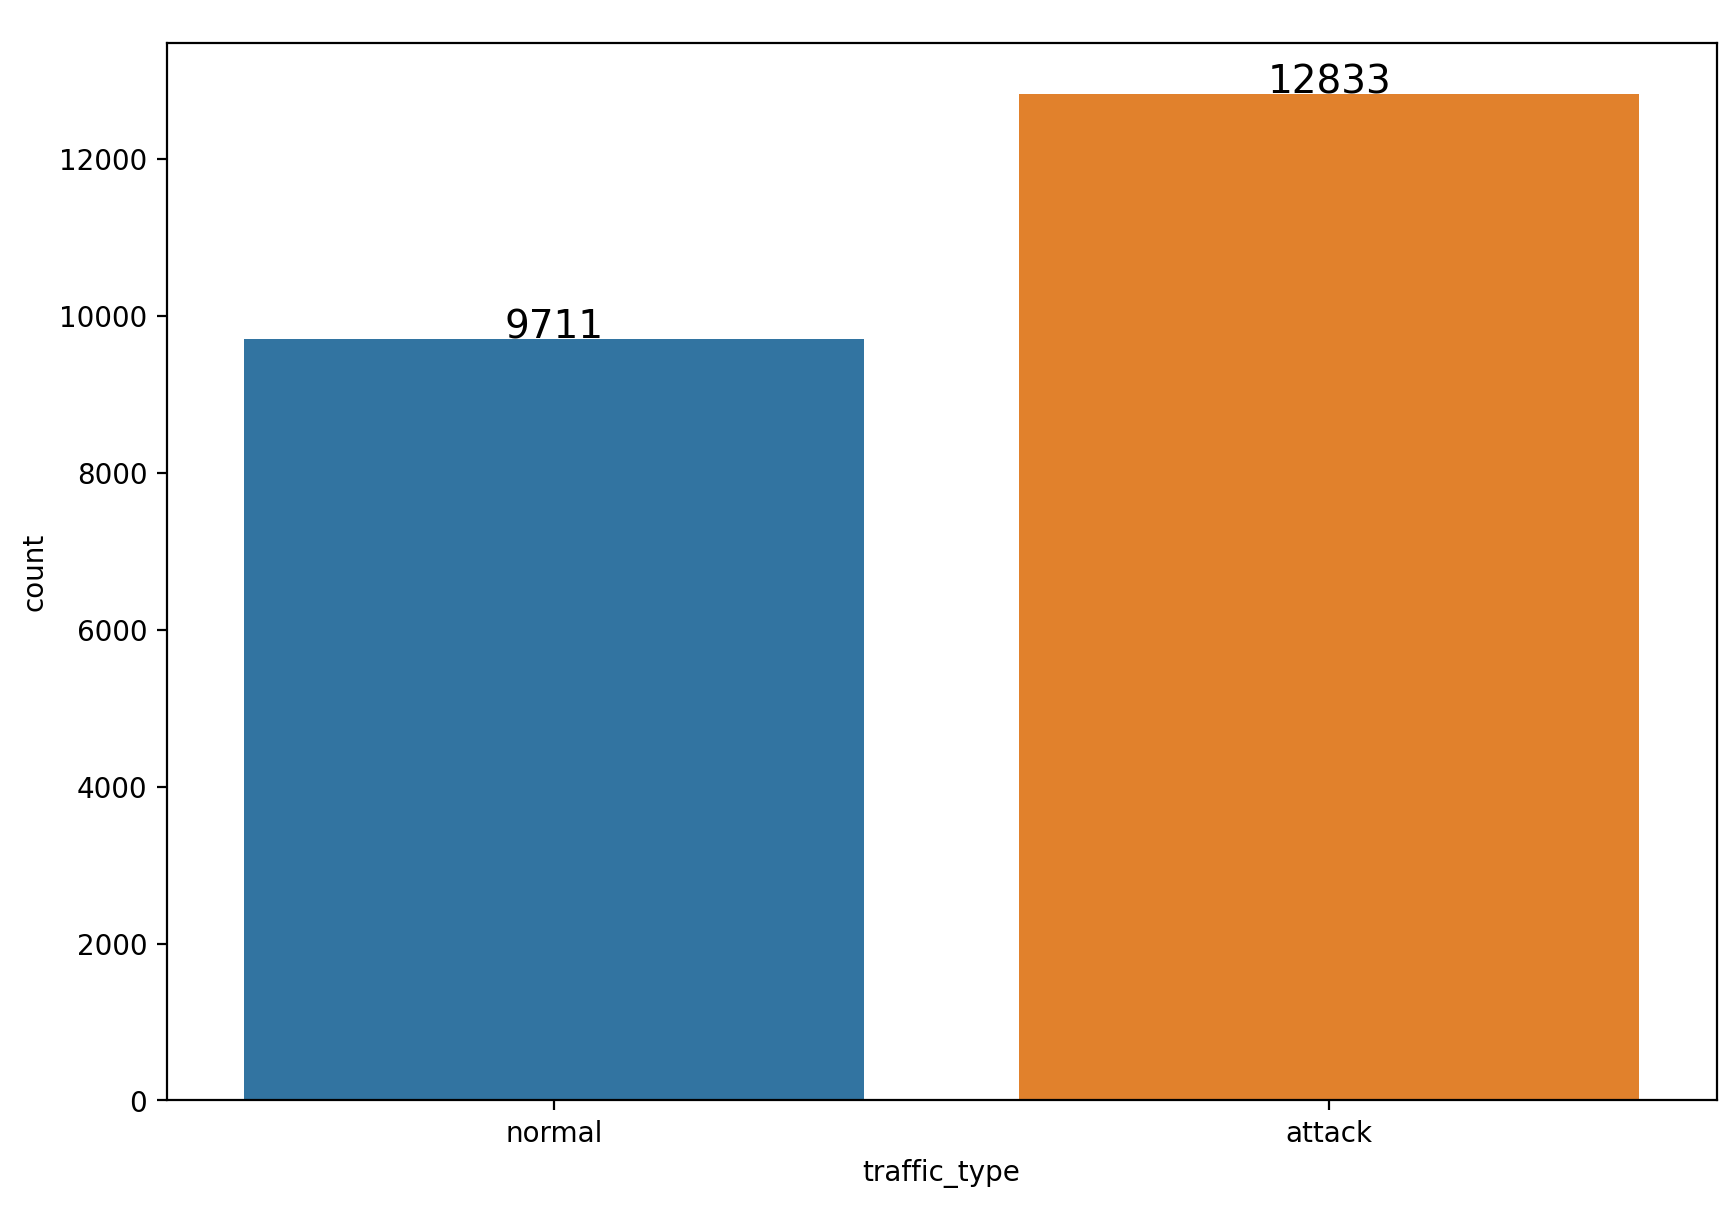

In [28]:
display_traffic_type(test_set)

## 2. Feature Encoding

### Label Encoder

In [29]:
from sklearn.preprocessing import LabelEncoder

def label_encode(df, cols):
    le = LabelEncoder()
    df[cols] = df[cols].apply(le.fit_transform)
    mapping = dict(zip(le.classes_, range(len(le.classes_))))
    return mapping

### One-hot Encoder

In [30]:
def hot_encode(df, categorical_columns = ['protocol_type', 'service', 'flag']):
    return pd.get_dummies(data=df, columns=categorical_columns, dtype='int8')

## 3. Normalization

In [31]:
from sklearn.preprocessing import MinMaxScaler

excl_cols = ['protocol_type', 'service', 'flag', 'category', 'traffic_type', 'attack_type', 'classifiers',
        'land', 'logged_in', 'is_host_login', 'is_guest_login']

def min_max_norm(df):
    scaler = MinMaxScaler()
    norm_cols = np.setdiff1d(df.columns, excl_cols)
    df[norm_cols] = scaler.fit_transform(df[norm_cols])

# Data Preparation

In [32]:
def remove_labels(df, labels):
    df.drop(labels, axis = 1, inplace = True)

In [33]:
def split(df, col):
    r = pd.DataFrame(df[col])
    df.drop(col, axis = 1, inplace = True)
    return r

In [49]:
def prep_2_class(df, add = True):
    n = df.copy()
    min_max_norm(n)
    
    if(add):
        n = add_missing_cols(n)
        
    h = hot_encode(n)
    l = split(h, ['traffic_type'])
    remove_labels(h, ['attack_type', 'category'])
    lh = hot_encode(l, ['traffic_type'])
    lm = label_encode(l, ['traffic_type'])
    return (h, lh, lm, l) #hot encoded set, hot encoded labels, label encoding mapping, encoded labels

In [51]:
def prep_4_class(df, add = True):
    n = df.copy()
    min_max_norm(n)

    if(add):
        n = add_missing_cols(n)
    
    h = hot_encode(n)
    l5 = pd.DataFrame(h['category'])
    lm5 = label_encode(l5, ['category'])
    
    r = h[h['category'] == 'normal']
    h.drop(r.index, axis = 0, inplace = True)
    
    l = split(h, ['category'])
    remove_labels(h, ['attack_type', 'traffic_type'])
    lh = hot_encode(l, ['category'])
    lm = label_encode(l, ['category'])
    return (h, lh, lm, l, lm5, l5)

#### Splitting KDDTrain+ dataset:

In [52]:
X_train, y_train, train_label_mapping, train_labels = prep_2_class(train_set, add=False)

In [53]:
X_train4, y_train4, train_label_mapping4, train_labels4, train_label_mapping5, train_labels5 = prep_4_class(train_set, add=False)

#### Splitting KDDTest+ dataset:

In [54]:
X_test, y_test, test_label_mapping, test_labels = prep_2_class(test_set)

In [55]:
X_test4, y_test4, test_label_mapping4, test_labels4, test_label_mapping5, test_labels5  = prep_4_class(test_set)

# XGBoost

**The parameters for the XGBoost model were chosen using randomized grid search**

**clf.best_params_**

{'reg_lambda': 0.5,
 'reg_alpha': 1,
 'learning_rate': 0.1,
 'importance_type': 'weight',
 'gamma': 0.1,
 'base_score': 0.5}

### Training for 2-class classification

In [40]:
booster = xgb.XGBClassifier(objective = 'binary:logistic', n_estimators = 100, use_label_encoder = False,
                          base_score =  0.5, reg_lambda = 0.5, reg_alpha = 1,  learning_rate = 0.1, 
                          importance_type = 'weight', eval_metric = 'logloss',
                          gamma = 0.1, random_state = 42)
booster.fit(X_train, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0.1, gpu_id=-1, importance_type='weight',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, random_state=42, reg_alpha=1, reg_lambda=0.5,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [41]:
def metrics_binary(y, pred):
    print('\nOverall accuracy: {:.4f}\n'.format(accuracy_score(y, pred)))

    print('\nClassification report\n')
    print(classification_report(y, pred, digits = 4, target_names=['attack', 'normal']))

## Binary Classification Results

### KDDTrain+

In [42]:
yhat_train_binary = booster.predict(X_train)
cm_train_binary = tf.math.confusion_matrix(labels = train_labels, predictions = yhat_train_binary)

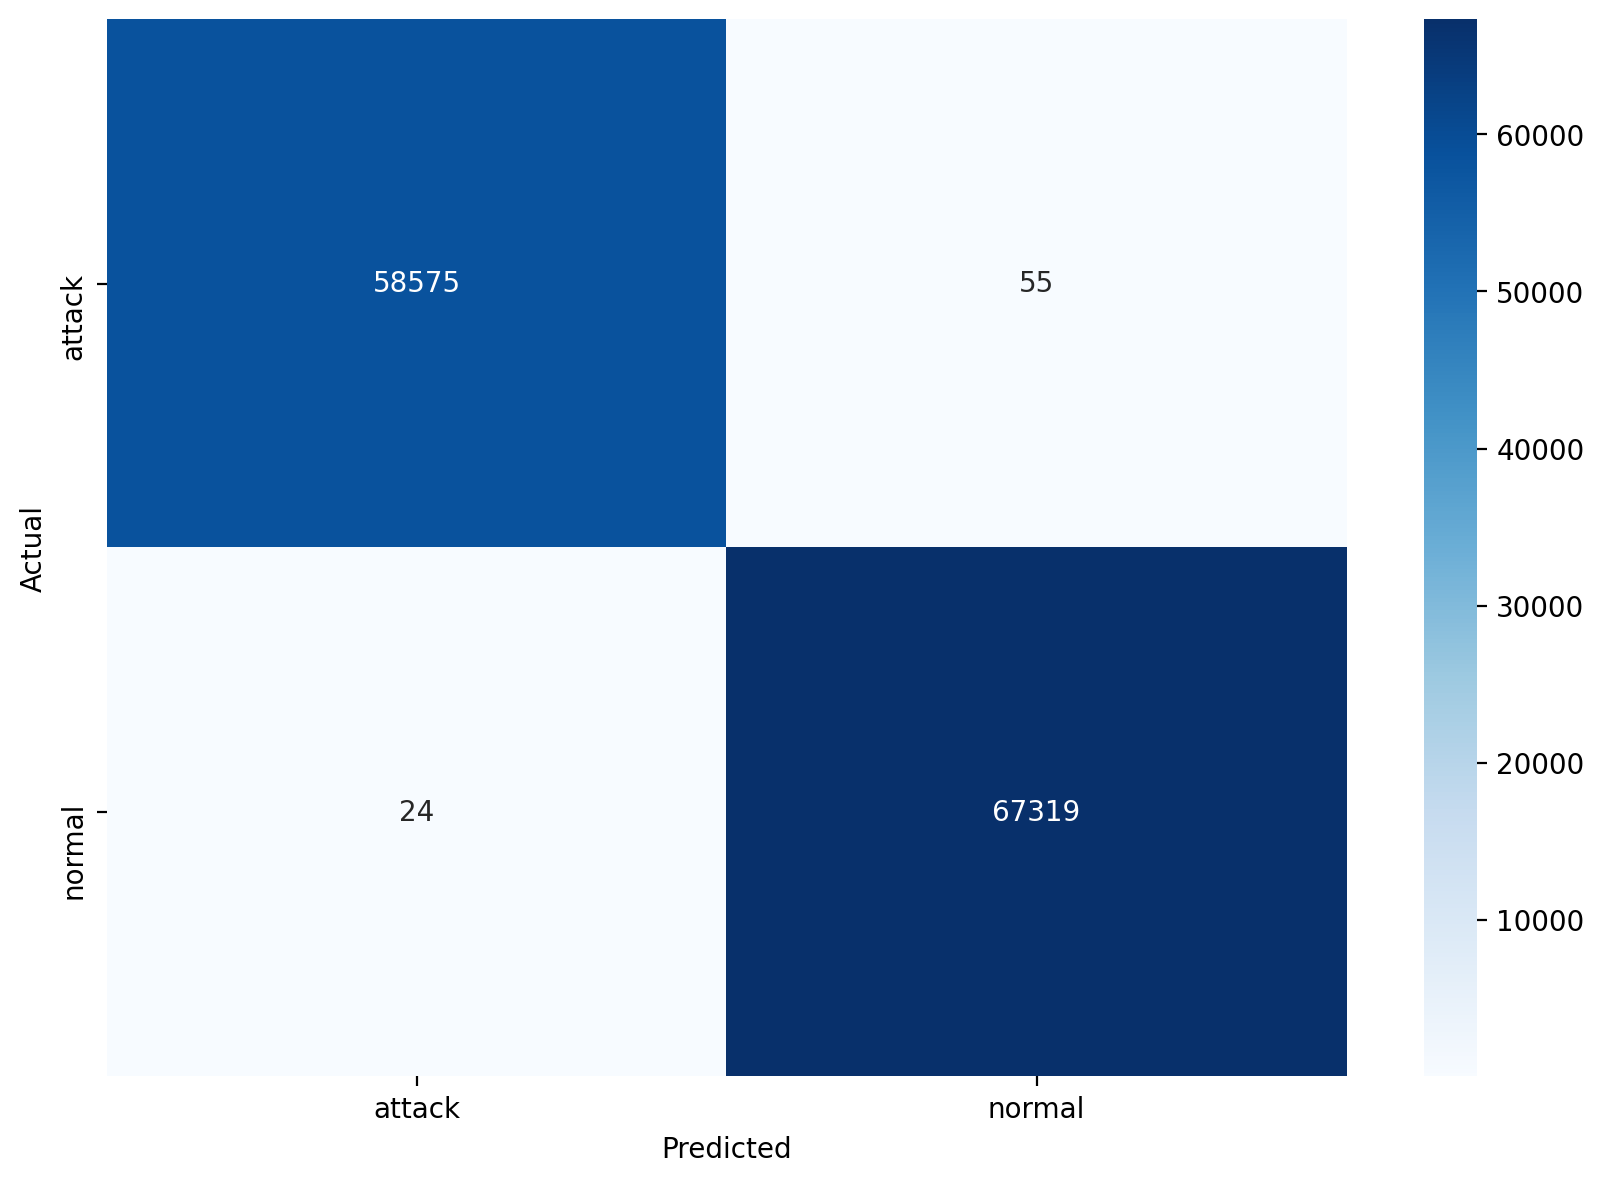

In [43]:
plt.figure(figsize =(10,7), dpi = 200)
sns.heatmap(cm_train_binary, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = train_label_mapping.keys(),
           yticklabels = train_label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [44]:
metrics_binary(train_labels, yhat_train_binary)


Overall accuracy: 0.9994


Classification report

              precision    recall  f1-score   support

      attack     0.9996    0.9991    0.9993     58630
      normal     0.9992    0.9996    0.9994     67343

    accuracy                         0.9994    125973
   macro avg     0.9994    0.9994    0.9994    125973
weighted avg     0.9994    0.9994    0.9994    125973



### KDDTest+

In [45]:
yhat_test_binary = booster.predict(X_test)
cm_test_binary = tf.math.confusion_matrix(labels = test_labels, predictions = yhat_test_binary)

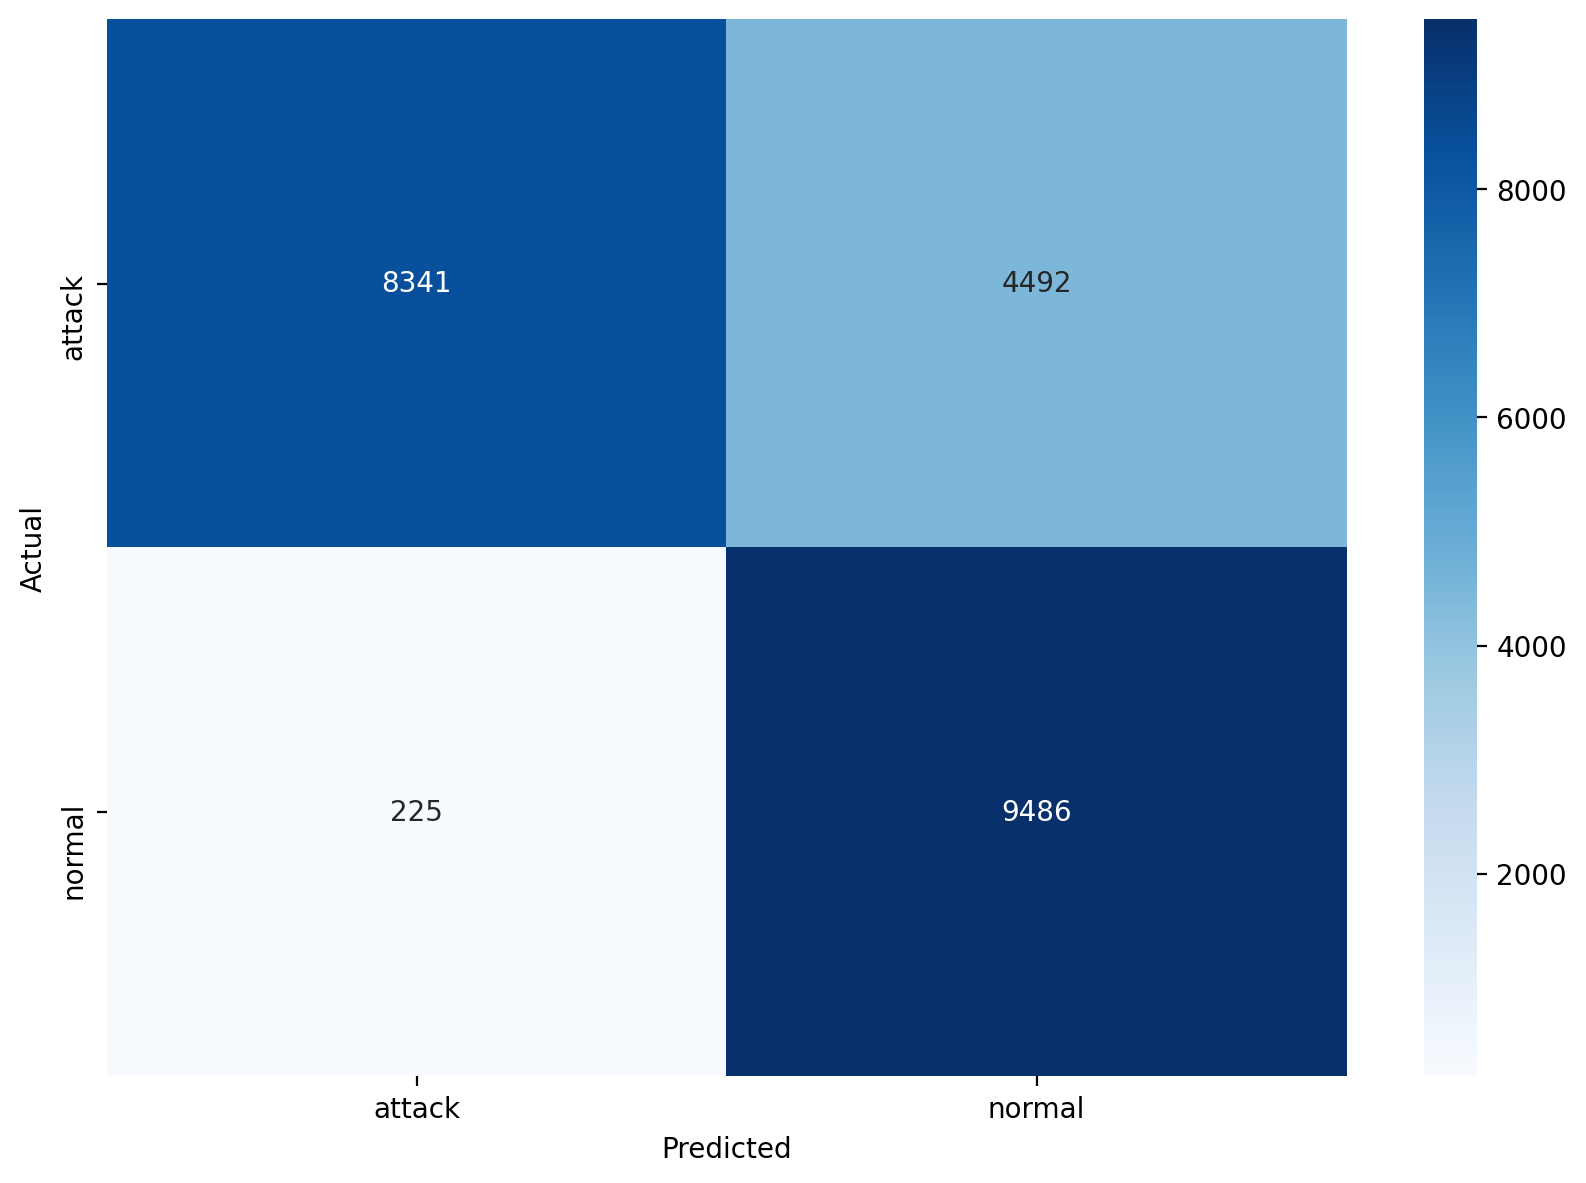

In [46]:
plt.figure(figsize =(10,7), dpi = 200)
sns.heatmap(cm_test_binary, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = test_label_mapping.keys(),
           yticklabels = test_label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [47]:
metrics_binary(test_labels, yhat_test_binary)


Overall accuracy: 0.7908


Classification report

              precision    recall  f1-score   support

      attack     0.9737    0.6500    0.7796     12833
      normal     0.6786    0.9768    0.8009      9711

    accuracy                         0.7908     22544
   macro avg     0.8262    0.8134    0.7902     22544
weighted avg     0.8466    0.7908    0.7887     22544



# Autoencoder and DNN

Random generators are seeded for the purpose of obtaining reproducible results. However, due to the inherent randomness of neural networks, this approach was not completely effective.

In [48]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

### Training for 4-class classification

## Deep Autoencoder

In [56]:
encoder = keras.models.Sequential(name = 'encoder')                 
encoder.add(keras.layers.Dense(100, activation = 'relu', input_shape = (121, ), kernel_initializer = 'he_uniform'))
encoder.add(keras.layers.Dense(20, activation = 'relu', kernel_initializer = 'he_uniform'))

decoder = keras.models.Sequential(name = 'decoder')
decoder.add(keras.layers.Dense(100, activation='relu', input_shape = (20, ), kernel_initializer = 'he_uniform')) 
decoder.add(keras.layers.Dense(121, activation='sigmoid', kernel_initializer = 'he_uniform'))

deep_ae = keras.models.Sequential([
    encoder,
    decoder
])

deep_ae.compile(
    loss = 'binary_crossentropy',
    optimizer= keras.optimizers.Adam(learning_rate=0.01)
)

deep_ae_history = deep_ae.fit(X_train4, X_train4, batch_size= 256, epochs=30)

Epoch 1/30
230/230 [==============================] - 1s 1ms/step - loss: 0.0460
Epoch 2/30
230/230 [==============================] - 0s 1ms/step - loss: 0.0180
Epoch 3/30
230/230 [==============================] - 0s 1ms/step - loss: 0.0170
Epoch 4/30
230/230 [==============================] - 0s 1ms/step - loss: 0.0167
Epoch 5/30
230/230 [==============================] - 0s 1ms/step - loss: 0.0164
Epoch 6/30
230/230 [==============================] - 0s 1ms/step - loss: 0.0163
Epoch 7/30
230/230 [==============================] - 0s 1ms/step - loss: 0.0162
Epoch 8/30
230/230 [==============================] - 0s 1ms/step - loss: 0.0161
Epoch 9/30
230/230 [==============================] - 0s 1ms/step - loss: 0.0161
Epoch 10/30
230/230 [==============================] - 0s 1ms/step - loss: 0.0160
Epoch 11/30
230/230 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 12/30
230/230 [==============================] - 0s 1ms/step - loss: 0.0159
Epoch 13/30
230/230 [====

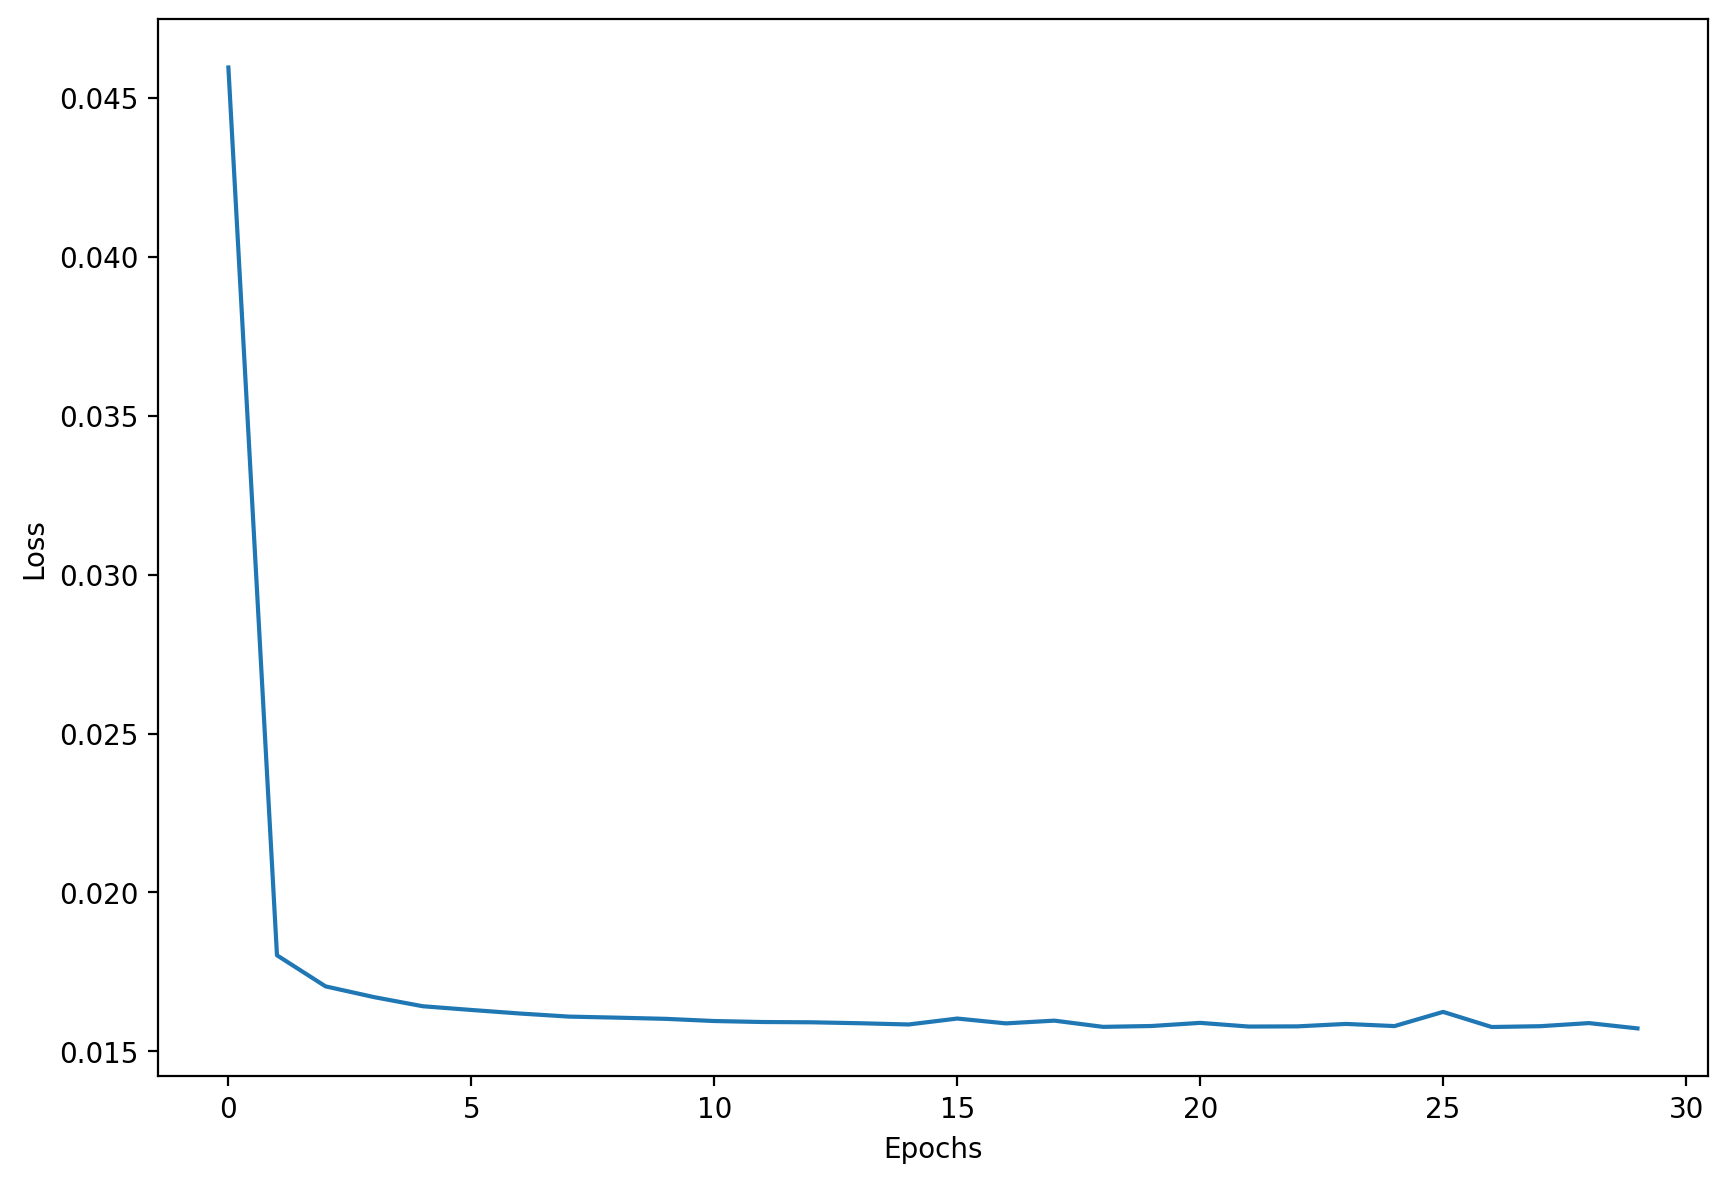

In [57]:
plt.figure(figsize =(10,7), dpi = 200)
plt.axes(xlabel = 'Epochs',
        ylabel = 'Loss')
plt.plot(deep_ae_history.history['loss']);

In [58]:
encoder_layers = deep_ae.get_layer('encoder')
encoder_layers.trainable = False

dnn = keras.models.Sequential([ 
    encoder_layers,
    keras.layers.Dense(4, input_shape=(20, ), activation = 'softmax', kernel_initializer = 'he_uniform')
])

dnn.compile(
    loss = 'binary_crossentropy',
    optimizer= keras.optimizers.Adam(learning_rate=0.01),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
              
)

dnn_history = dnn.fit(X_train4, y_train4, batch_size= 256, epochs = 50)

Epoch 1/50
230/230 [==============================] - 1s 766us/step - loss: 0.1408 - accuracy: 0.9208 - precision: 0.9242 - recall: 0.9183
Epoch 2/50
230/230 [==============================] - 0s 752us/step - loss: 0.0437 - accuracy: 0.9771 - precision: 0.9783 - recall: 0.9760
Epoch 3/50
230/230 [==============================] - 0s 753us/step - loss: 0.0304 - accuracy: 0.9849 - precision: 0.9851 - recall: 0.9846
Epoch 4/50
230/230 [==============================] - 0s 754us/step - loss: 0.0260 - accuracy: 0.9881 - precision: 0.9884 - recall: 0.9878
Epoch 5/50
230/230 [==============================] - 0s 759us/step - loss: 0.0235 - accuracy: 0.9896 - precision: 0.9899 - recall: 0.9893
Epoch 6/50
230/230 [==============================] - 0s 763us/step - loss: 0.0223 - accuracy: 0.9898 - precision: 0.9900 - recall: 0.9895
Epoch 7/50
230/230 [==============================] - 0s 752us/step - loss: 0.0214 - accuracy: 0.9900 - precision: 0.9903 - recall: 0.9897
Epoch 8/50
230/230 [=======

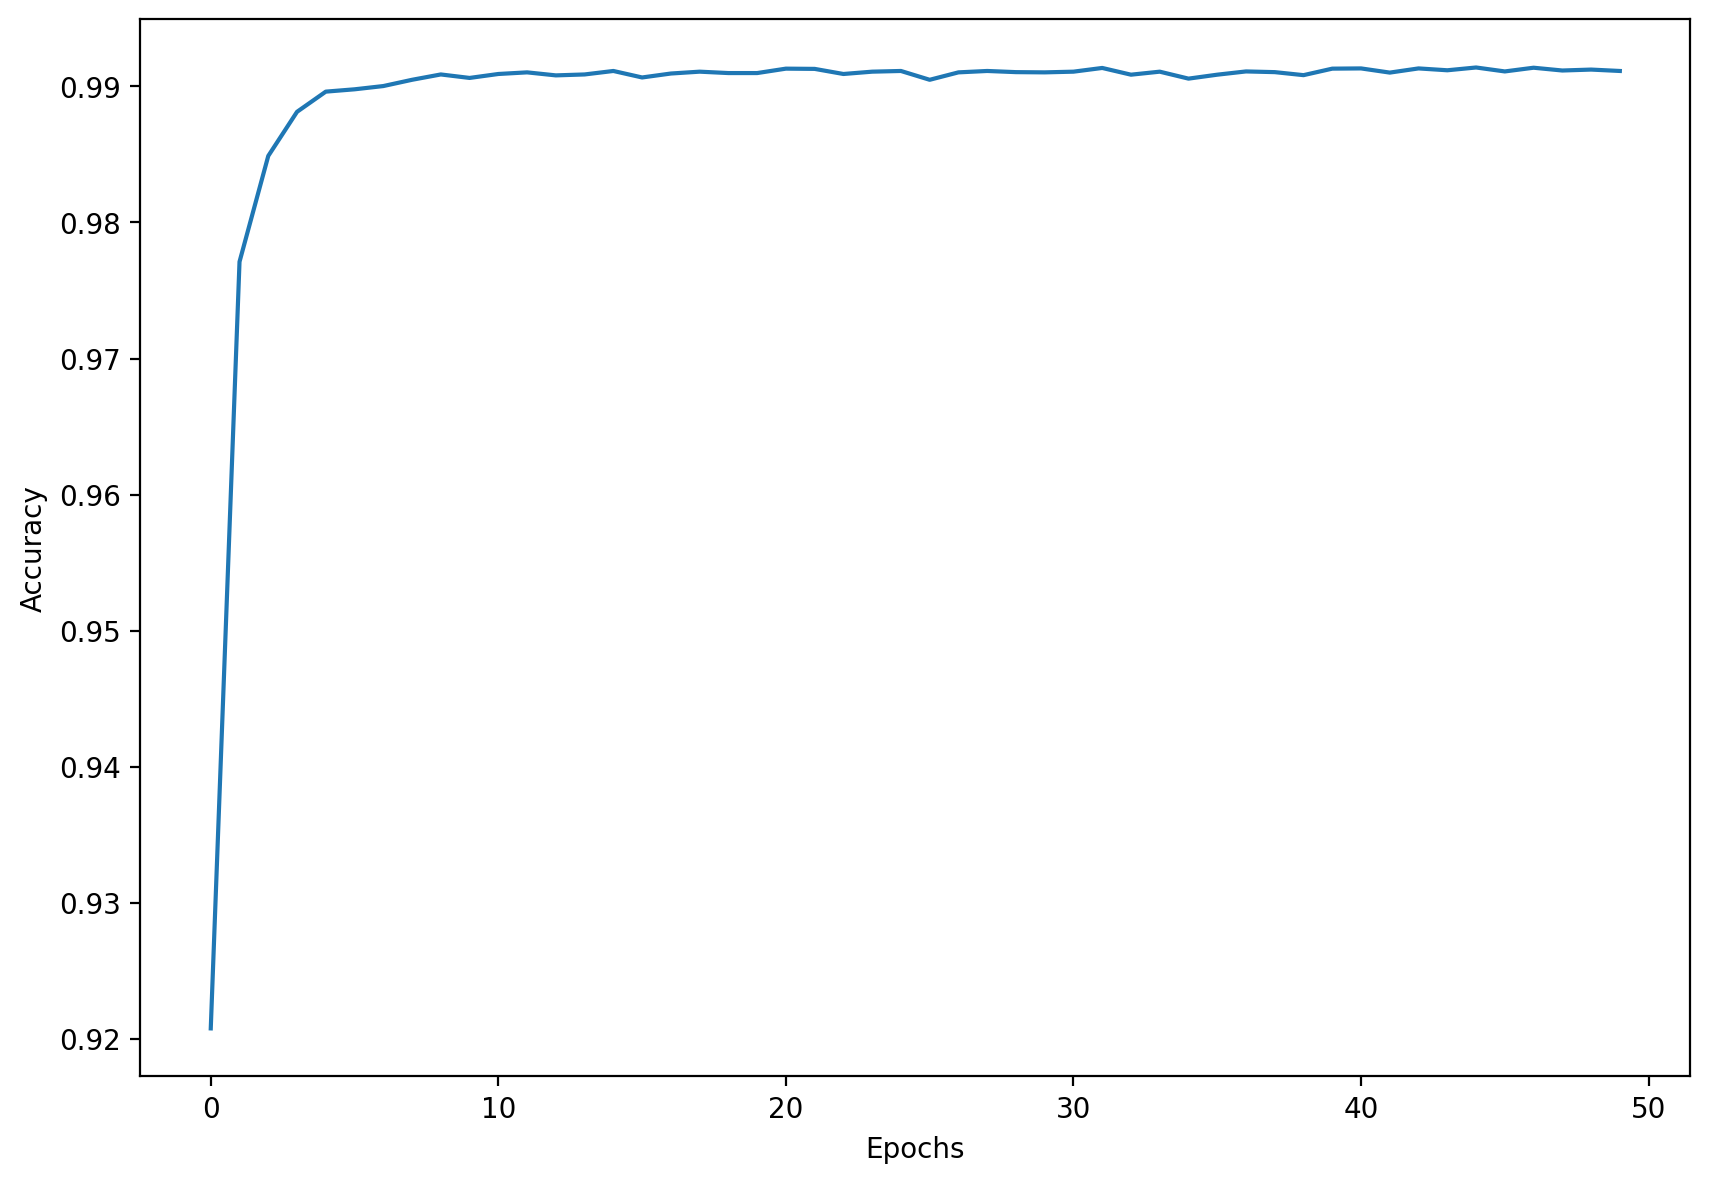

In [59]:
plt.figure(figsize =(10,7), dpi = 200)
plt.axes(xlabel = 'Epochs',
        ylabel = 'Accuracy')
plt.plot(dnn_history.history['accuracy']);

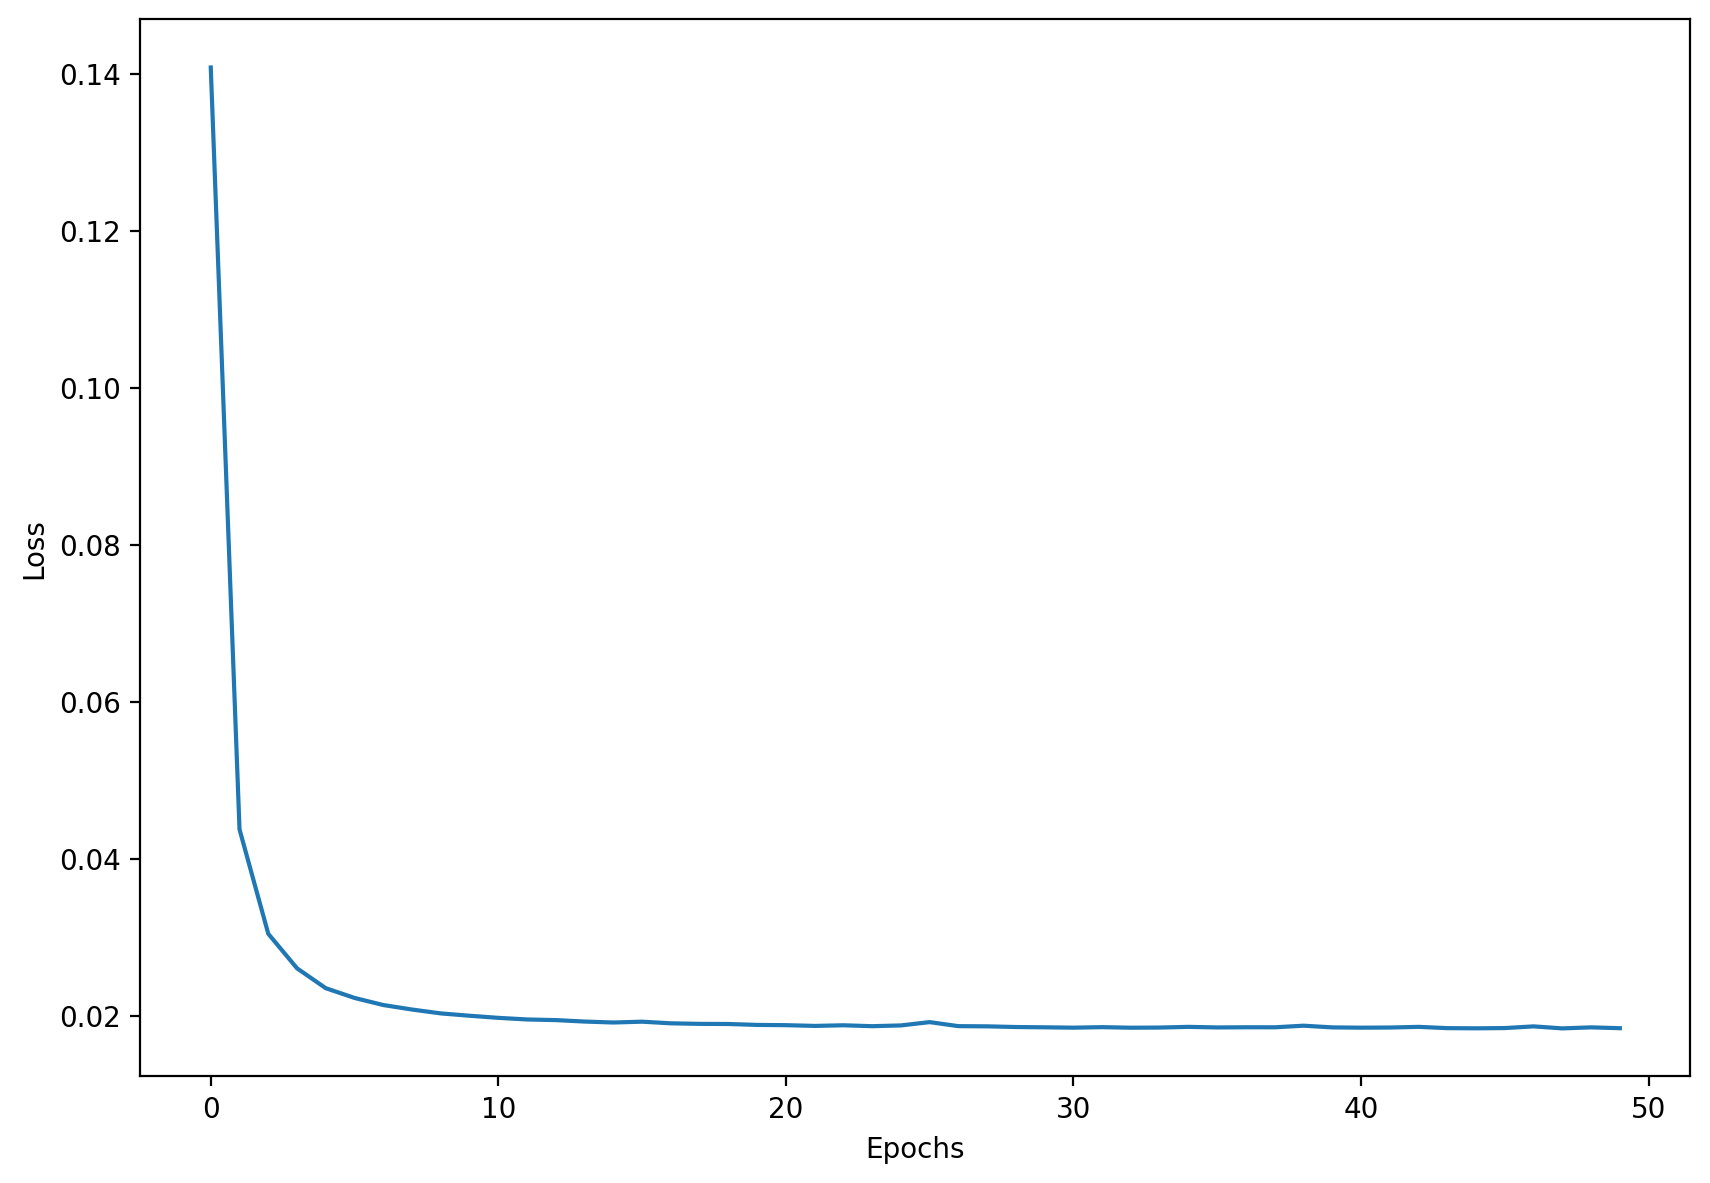

In [60]:
plt.figure(figsize =(10,7), dpi = 200)
plt.axes(xlabel = 'Epochs',
        ylabel = 'Loss')
plt.plot(dnn_history.history['loss']);

# Multi-Class classification results

**Previously saved weights that produced the best results**

In [61]:
dnn.load_weights('best results weights.h5')

### Original Data

In [62]:
def metrics(y, pred):
    print('\nOverall accuracy: {:.4f}\n'.format(accuracy_score(y, pred)))

    print('\nClassification report\n')
    print(classification_report(y, pred, digits = 4, target_names=['dos', 'probe', 'r2l', 'u2r']))

In [63]:
yhat_train = dnn.predict(X_train4)
yhat_train_labels = [np.argmax(i) for i in yhat_train]
cm_train = tf.math.confusion_matrix(labels = train_labels4, 
                               predictions = yhat_train_labels)

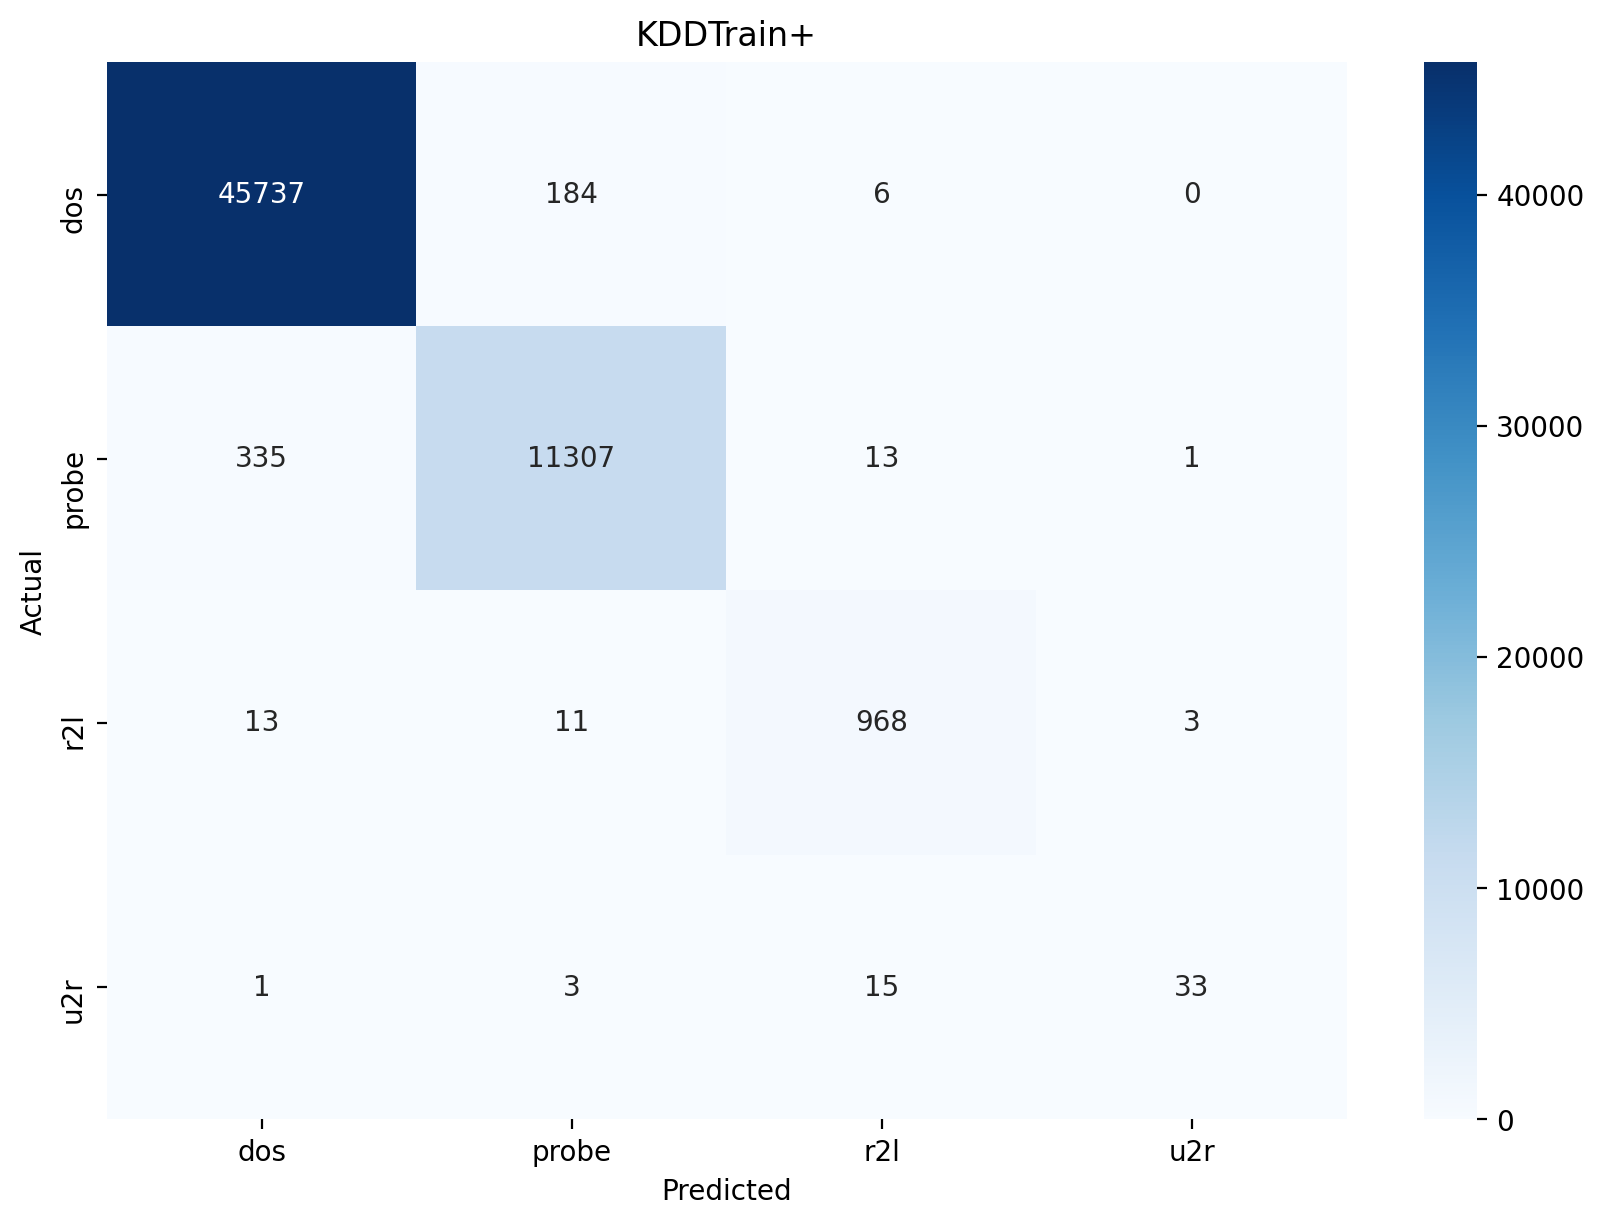

In [64]:
plt.figure(figsize =(10,7), dpi = 200)
plt.title('KDDTrain+')
sns.heatmap(cm_train, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = train_label_mapping4.keys(),
           yticklabels = train_label_mapping4.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [65]:
metrics(train_labels4, yhat_train_labels)


Overall accuracy: 0.9900


Classification report

              precision    recall  f1-score   support

         dos     0.9924    0.9959    0.9941     45927
       probe     0.9828    0.9701    0.9764     11656
         r2l     0.9661    0.9729    0.9695       995
         u2r     0.8919    0.6346    0.7416        52

    accuracy                         0.9900     58630
   macro avg     0.9583    0.8934    0.9204     58630
weighted avg     0.9900    0.9900    0.9900     58630



In [66]:
yhat_test = dnn.predict(X_test4)
yhat_test_labels = [np.argmax(i) for i in yhat_test]
cm_test = tf.math.confusion_matrix(labels = test_labels4, 
                              predictions = yhat_test_labels)

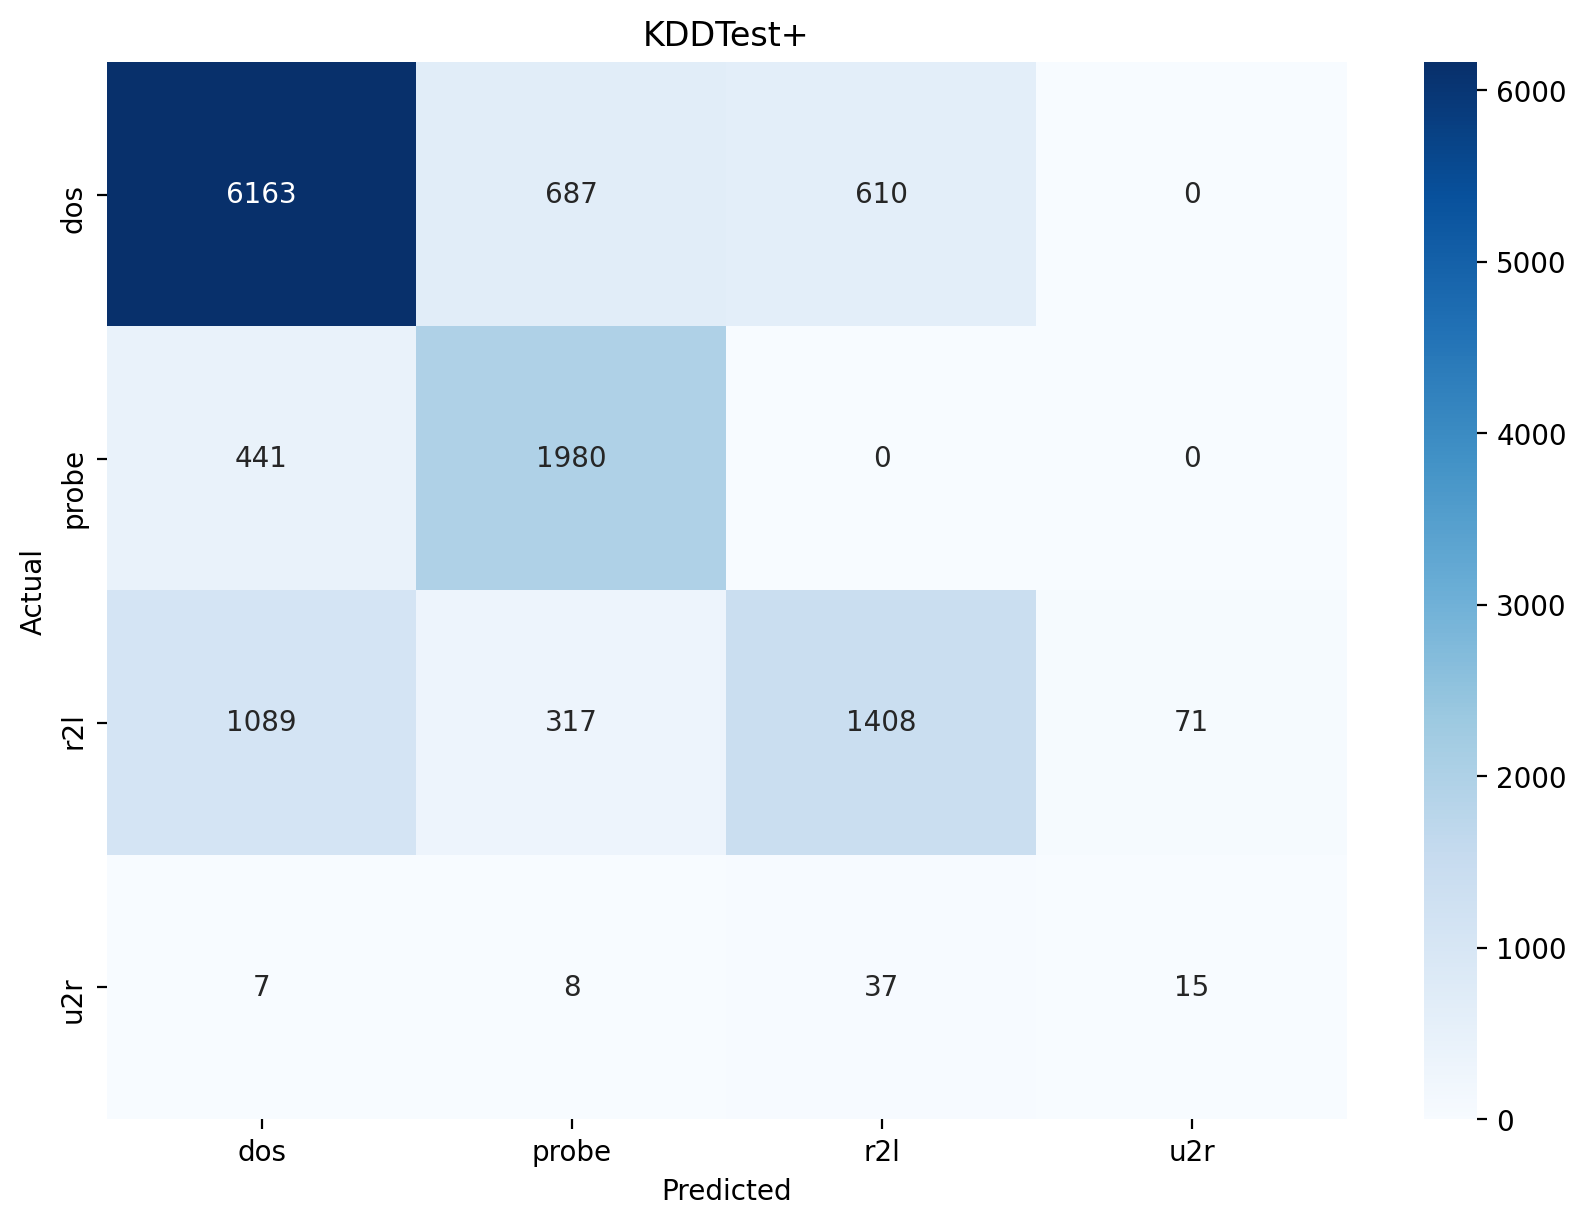

In [67]:
plt.figure(figsize =(10,7), dpi = 200)
plt.title('KDDTest+')
sns.heatmap(cm_test, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = test_label_mapping4.keys(),
           yticklabels = test_label_mapping4.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [68]:
metrics(test_labels4, yhat_test_labels)


Overall accuracy: 0.7454


Classification report

              precision    recall  f1-score   support

         dos     0.8004    0.8261    0.8131      7460
       probe     0.6618    0.8178    0.7316      2421
         r2l     0.6852    0.4880    0.5700      2885
         u2r     0.1744    0.2239    0.1961        67

    accuracy                         0.7454     12833
   macro avg     0.5804    0.5890    0.5777     12833
weighted avg     0.7451    0.7454    0.7398     12833



### Predictions from XGBoost Model

In [69]:
def metrics5(y, pred):
    print('\nOverall accuracy: {:.4f}\n'.format(accuracy_score(y, pred)))

    print('\nClassification report\n')
    print(classification_report(y, pred, digits = 4, target_names=['dos', 'normal', 'probe', 'r2l', 'u2r']))

In [71]:
def realign_labels_neg(p):
    return [x-1 if x != 0 else 0 for x in p]

### KDDTest+

In [72]:
train_label_mapping

{'attack': 0, 'normal': 1}

In [73]:
train_label_mapping5

{'dos': 0, 'normal': 1, 'probe': 2, 'r2l': 3, 'u2r': 4}

In [82]:
i_train = yhat_train_binary.copy()
int_4 = (train_labels4.index).intersection(i_train4)
X_train_w = X_train.iloc[int_4]
train_labels_w = train_labels5.iloc[int_4]

In [83]:
yhat_train_w = dnn.predict(X_train_w)
yhat_train_labels_w = [np.argmax(i) for i in yhat_train_w]
train_labels_w_ = realign_labels_neg(train_labels_w['category'])
cm_train_w = tf.math.confusion_matrix(labels = train_labels_w_, 
                               predictions = yhat_train_labels_w)

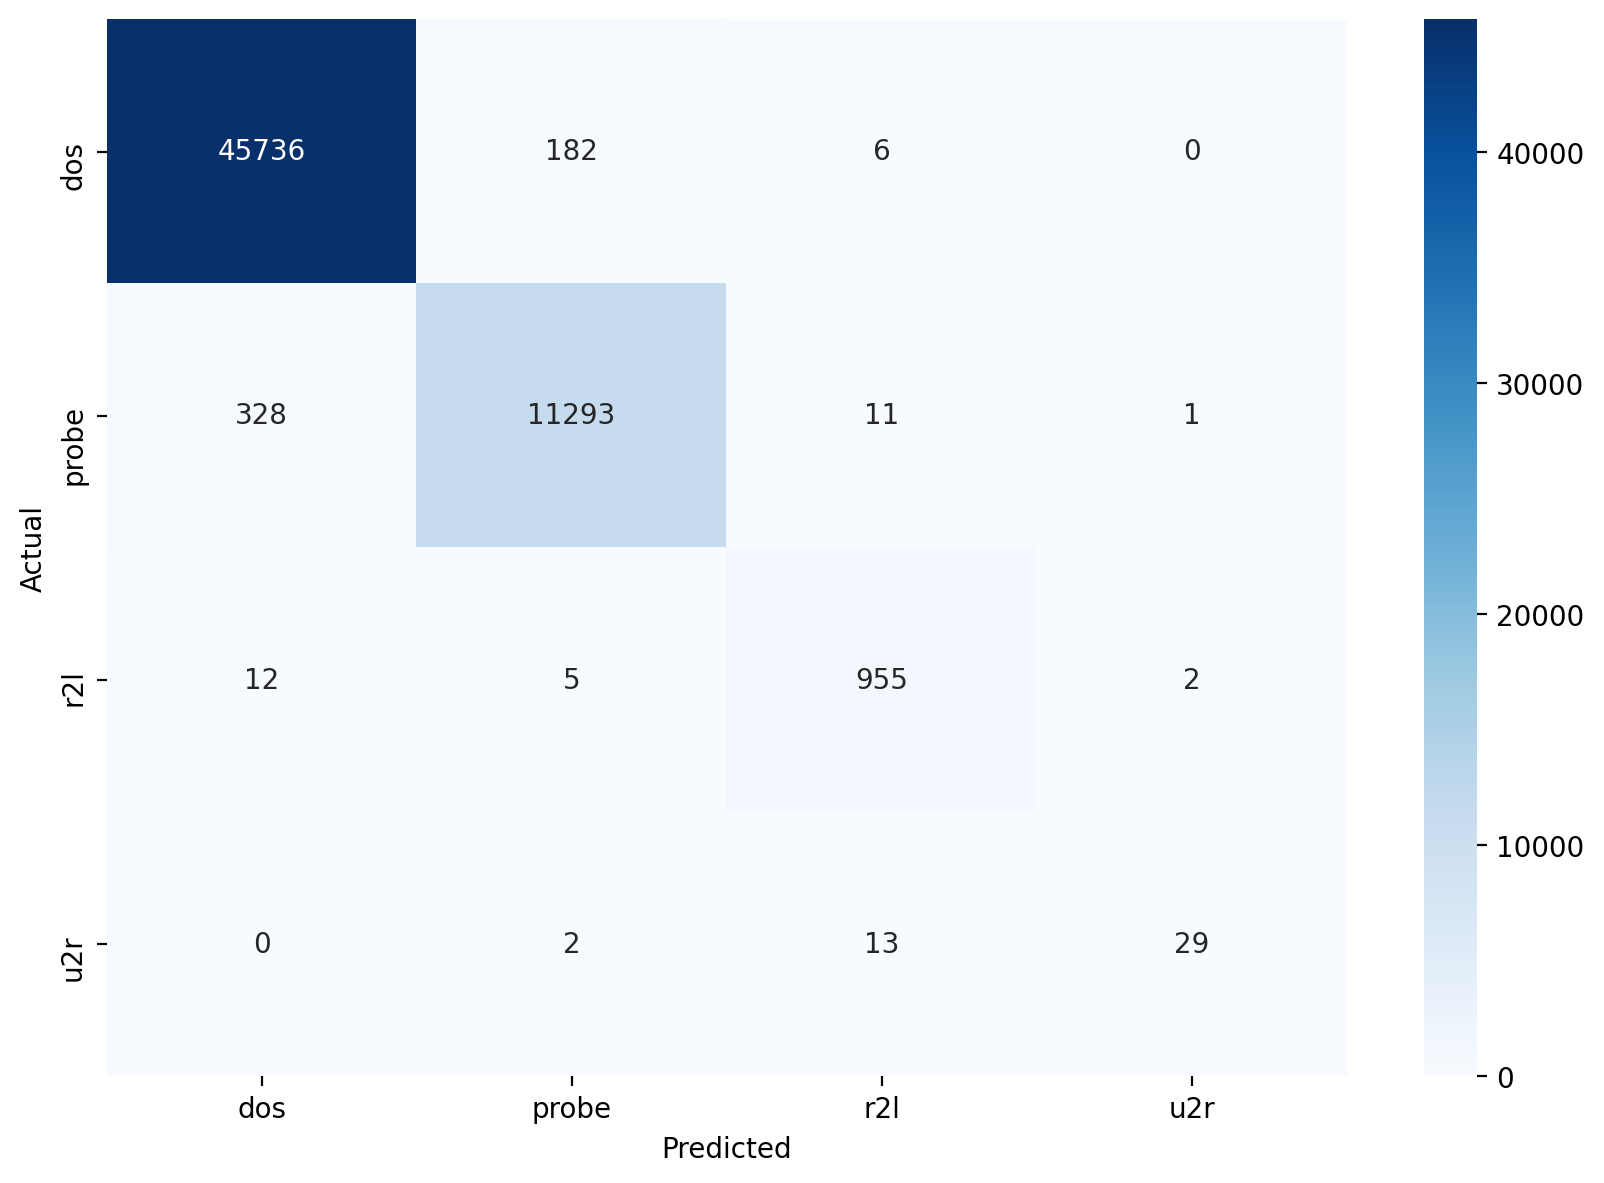

In [84]:
plt.figure(figsize =(10,7), dpi = 200)
#plt.title('KDDTrain+')
sns.heatmap(cm_train_w, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = train_label_mapping4.keys(),
           yticklabels = train_label_mapping4.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [86]:
metrics(train_labels_w_, yhat_train_labels_w)


Overall accuracy: 0.9904


Classification report

              precision    recall  f1-score   support

         dos     0.9926    0.9959    0.9943     45924
       probe     0.9835    0.9708    0.9771     11633
         r2l     0.9695    0.9805    0.9750       974
         u2r     0.9062    0.6591    0.7632        44

    accuracy                         0.9904     58575
   macro avg     0.9630    0.9016    0.9274     58575
weighted avg     0.9904    0.9904    0.9904     58575



### KDDTest+

In [87]:
test_label_mapping

{'attack': 0, 'normal': 1}

In [88]:
test_label_mapping5

{'dos': 0, 'normal': 1, 'probe': 2, 'r2l': 3, 'u2r': 4}

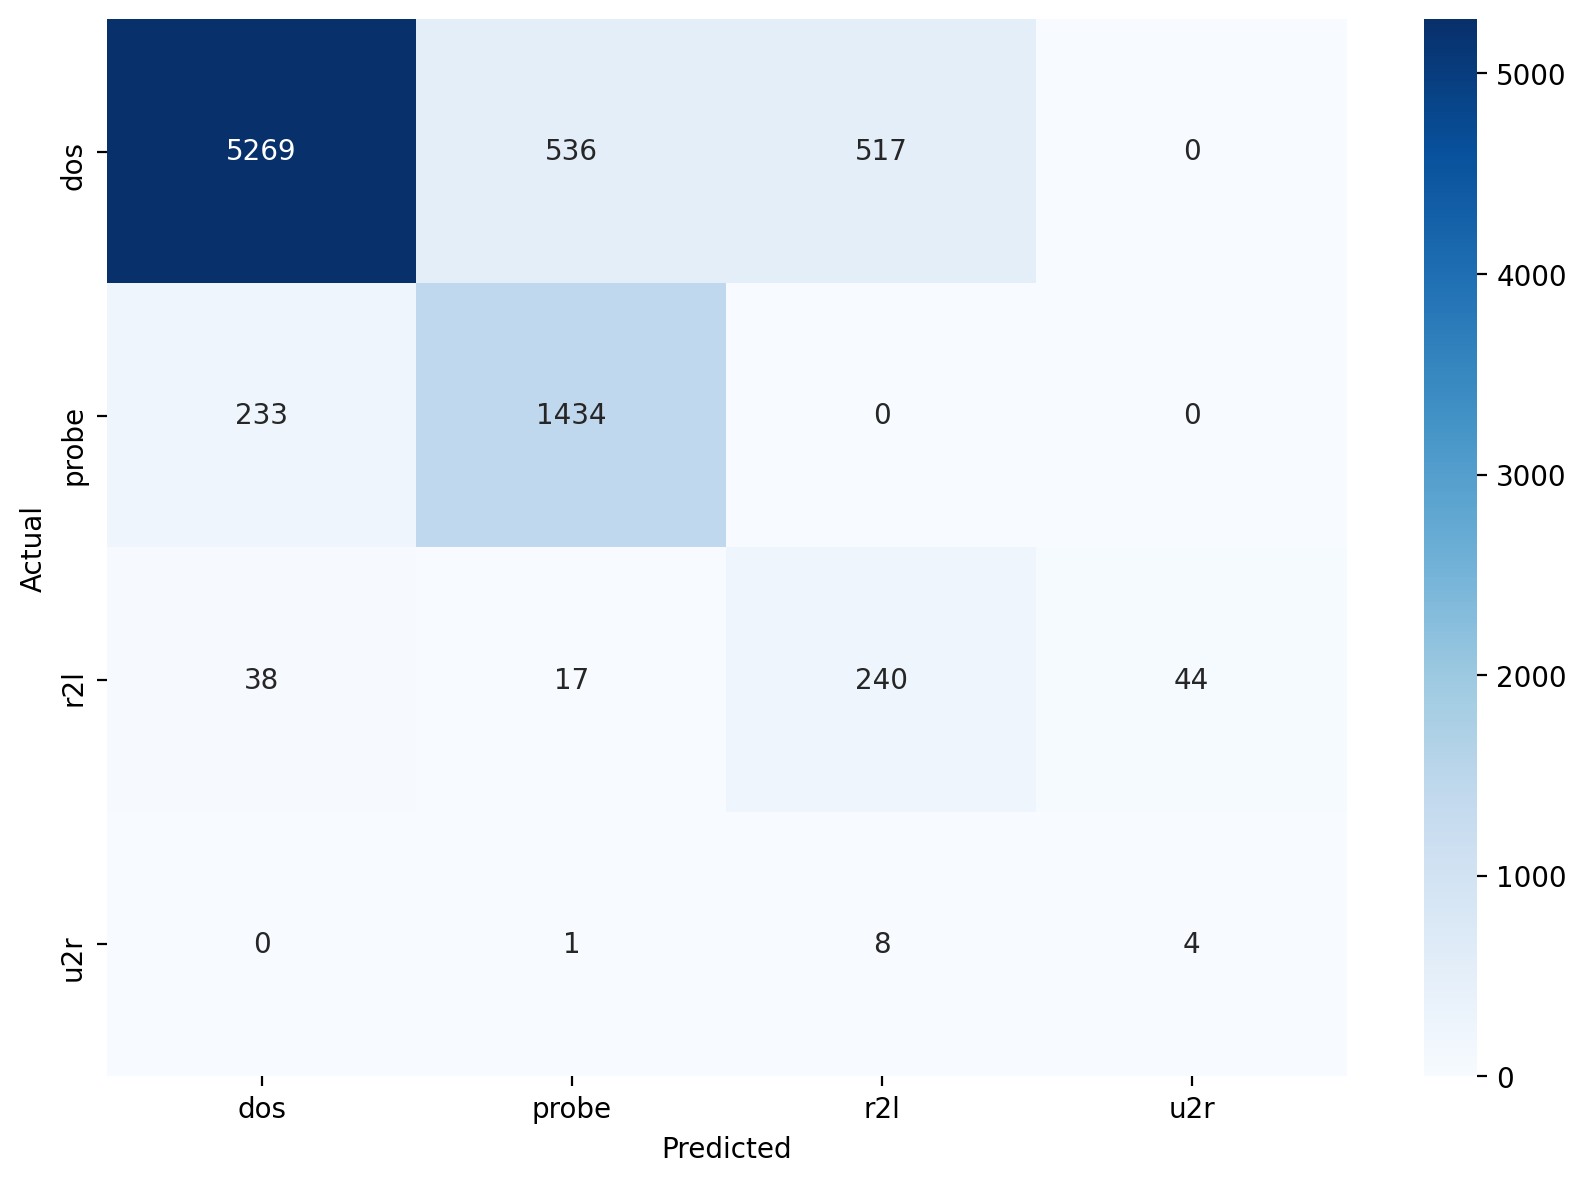

In [98]:
i_test = yhat_test_binary.copy()
int_4 = (test_labels4.index).intersection(i_test4)
X_test_w = X_test.iloc[int_4]
test_labels_w = test_labels5.iloc[int_4]

yhat_test_w = dnn.predict(X_test_w)
yhat_test_labels_w = [np.argmax(i) for i in yhat_test_w]
test_labels_w_ = realign_labels_neg(test_labels_w['category'])
cm_test_w = tf.math.confusion_matrix(labels = test_labels_w_, 
                               predictions = yhat_test_labels_w)


plt.figure(figsize =(10,7), dpi = 200)
#plt.title('KDDTest+')
sns.heatmap(cm_test_w, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = test_label_mapping4.keys(),
           yticklabels = test_label_mapping4.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [99]:
metrics(test_labels_w_, yhat_test_labels_w)


Overall accuracy: 0.8329


Classification report

              precision    recall  f1-score   support

         dos     0.9511    0.8334    0.8884      6322
       probe     0.7213    0.8602    0.7847      1667
         r2l     0.3137    0.7080    0.4348       339
         u2r     0.0833    0.3077    0.1311        13

    accuracy                         0.8329      8341
   macro avg     0.5174    0.6773    0.5597      8341
weighted avg     0.8779    0.8329    0.8480      8341

